# Noise Reduction

This jupyter notebook demonstrates possible ways to reduce noise from the recording (`.wav`) files.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

import IPython.display as ipd

%matplotlib inline

## Load .wav-file

In [20]:
audio_path = 'recording_20251121_221951.wav'  # This line needs to be adapted

y, sr = librosa.load(audio_path, sr=None)
print(f'Samplerate: {sr} Hz, Duration: {len(y) / sr:.2f} seconds')

ipd.display(ipd.Audio(y, rate=sr))

Samplerate: 44100 Hz, Duration: 5.32 seconds


## Waveform

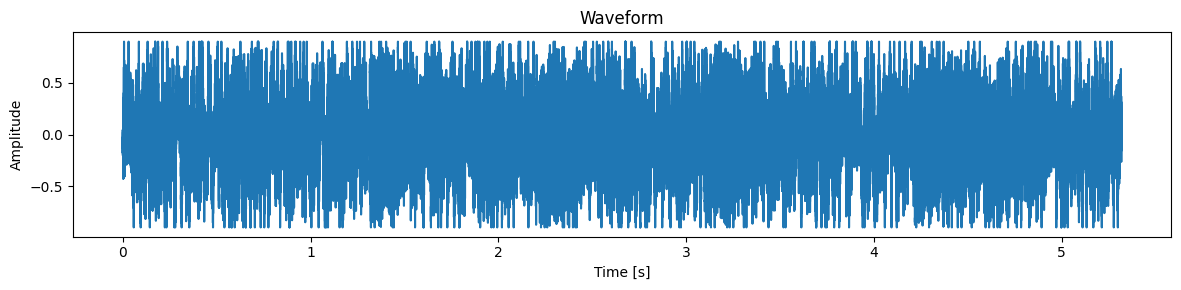

In [21]:
t = np.arange(len(y)) / sr

plt.figure(figsize=(12, 3))
plt.plot(t, y)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.tight_layout()
plt.show()

## Compute STFT

Shift shape: (1025, 459)


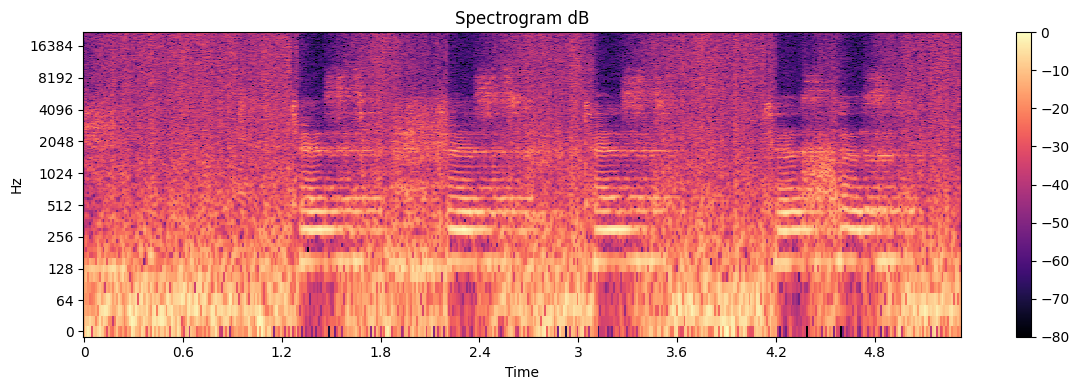

In [22]:
S_complex = librosa.stft(y)
S_full, phase = librosa.magphase(S_complex)

print(f'Shift shape: {S_full.shape}')

plt.figure(figsize=(12, 4))

librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.colorbar()
plt.title('Spectrogram dB')
plt.tight_layout()
plt.show()

## REPET-SIM

In [23]:
def reduce_noise_librosa_repet(y, sr, margin_i=2, margin_v=10, power=2):
    S_complex = librosa.stft(y)
    S_full, phase = librosa.magphase(S_complex)

    # Similarity filter (median)
    S_filter = librosa.decompose.nn_filter(
        S_full,
        aggregate=np.median,
        metric='cosine',
        width=int(librosa.time_to_frames(2, sr=sr))
    )

    S_filter = np.minimum(S_full, S_filter)

    mask_i = librosa.util.softmask(
        S_filter,
        margin_i * (S_full - S_filter),
        power=power
    )

    mask_v = librosa.util.softmask(
        S_full - S_filter,
        margin_v * S_filter,
        power=power
    )

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full

    y_foreground = librosa.istft(S_foreground * phase)
    y_background = librosa.istft(S_background * phase)

    return y_foreground, y_background, S_full, S_foreground, S_background, mask_v, mask_i

## Run noise reduction

In [24]:
y_fg, y_bg, S_full, S_fg, S_bg, mask_v, mask_i = reduce_noise_librosa_repet(y, sr)

print('Original audio:')
ipd.display(ipd.Audio(y, rate=sr))

print('Foreground (cleaned):')
ipd.display(ipd.Audio(y_fg, rate=sr))

print('Background (noise/residual):')
ipd.display(ipd.Audio(y_bg, rate=sr))


Original audio:


Foreground (cleaned):


Background (noise/residual):


## Spectrogram Comparison

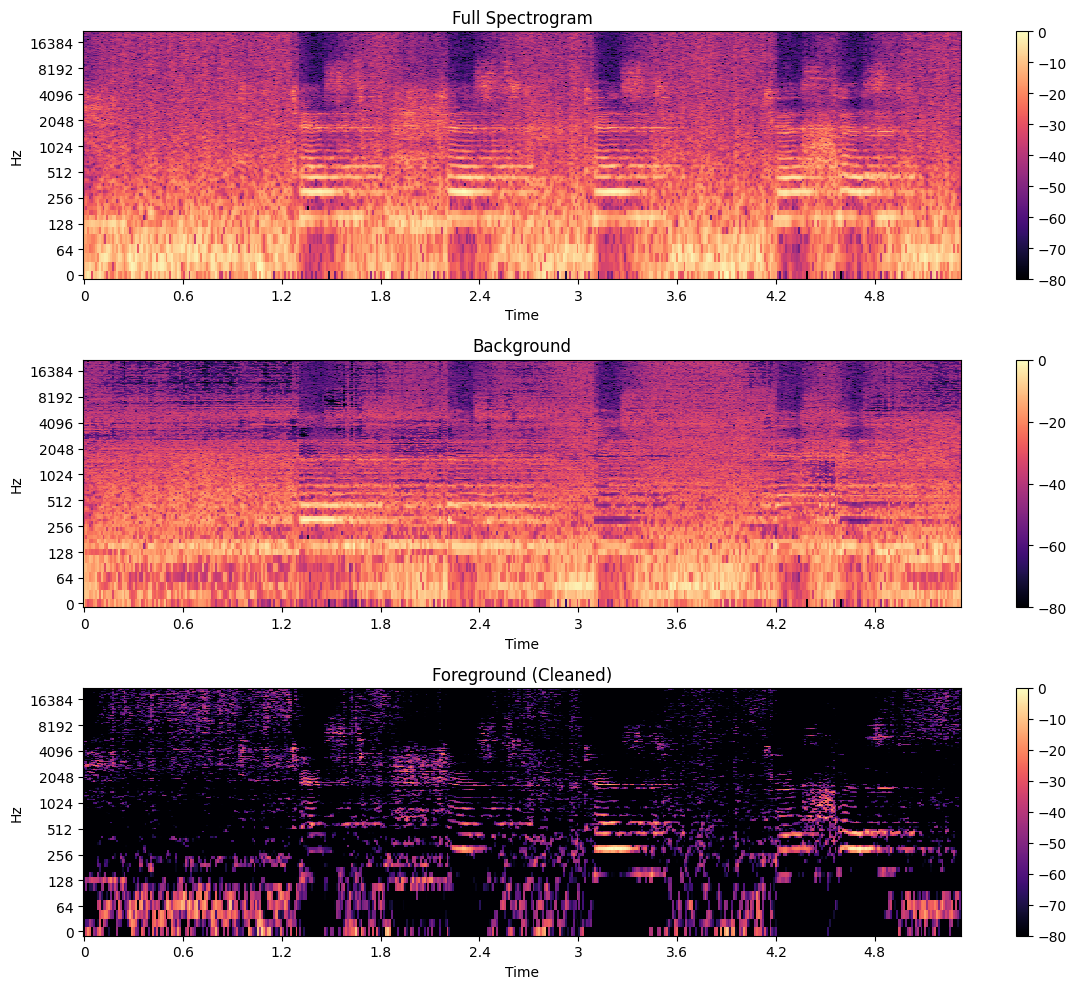

In [25]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Full Spectrogram')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_bg, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Background')
plt.colorbar()

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_fg, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground (Cleaned)')
plt.colorbar()

plt.tight_layout()
plt.show()